In [9]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
from gensim.models import Word2Vec
import nltk
nltk.download('wordnet')
stemmer = SnowballStemmer('english')
import unicodedata
from numpy import dot
from numpy.linalg import norm
# Lemmatize with POS Tag
from nltk.corpus import wordnet

#import cv2
%matplotlib inline
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/prajwalkrishn/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
data = pd.read_json('../Data/corpus2.json')
data.head(5)

,id,cve,project_name,description,mistakes,tag_list
0,1037,CVE-2014-7948,chromium,Google Chrome caches pages despite having an S...,I think that the vulenrability is interesting ...,"[{'id': 8, 'tag': 'bounty'}, {'id': 95, 'tag':..."
1,1158,CVE-2015-6757,chromium,Trying to access data in ServiceWorker after i...,The mistake made here was a basic C coding mis...,"[{'id': 5, 'tag': 'lifetime-1y2y'}, {'id': 8, ..."
2,1489,CVE-2017-5125,chromium,Embargoed. Heap overflow in Skia.\n,None,"[{'id': 14, 'tag': 'cwe-119'}, {'id': 357, 'ta..."
3,184,CVE-2010-4488,chromium,This bug involves an unhandled case in which t...,"This could be a coding or design error, there ...","[{'id': 3, 'tag': 'lifetime-90d180d'}, {'id': ..."
4,1269,CVE-2016-1682,chromium,Checks to verify the content security policy (...,It seems as though the developer just didn't t...,"[{'id': 1, 'tag': 'lifetime-30d'}, {'id': 8, '..."


In [11]:
CVE_description_mistake = data[['id','cve','description','mistakes']].copy()

In [12]:
CVE_description_mistake

,id,cve,description,mistakes
0,1037,CVE-2014-7948,Google Chrome caches pages despite having an S...,I think that the vulenrability is interesting ...
1,1158,CVE-2015-6757,Trying to access data in ServiceWorker after i...,The mistake made here was a basic C coding mis...
2,1489,CVE-2017-5125,Embargoed. Heap overflow in Skia.\n,None
3,184,CVE-2010-4488,This bug involves an unhandled case in which t...,"This could be a coding or design error, there ..."
4,1269,CVE-2016-1682,Checks to verify the content security policy (...,It seems as though the developer just didn't t...
...,...,...,...,...
721,928,CVE-2014-1715,Path traversal vulnerability that can lead to ...,"Ultimately, this vunerability was the direct c..."
722,1853,CVE-2014-0116,A fix applied in a previous update didn't acco...,The correct sanitization regex pattern was pre...
723,1421,CVE-2017-5055,Use after free in printing. When the cross pro...,PrintPreviewDone() got called multiple times a...
724,55,CVE-2010-0656,"Webkit, if given a false directory in the URL ...",The origin of the bug is not really a commit o...


In [13]:
CVE_description_mistake['desc_mist'] = data['description'] + data['mistakes']

In [14]:
CVE_description_mistake
CVE_description_mistake.fillna('')

,id,cve,description,mistakes,desc_mist
0,1037,CVE-2014-7948,Google Chrome caches pages despite having an S...,I think that the vulenrability is interesting ...,Google Chrome caches pages despite having an S...
1,1158,CVE-2015-6757,Trying to access data in ServiceWorker after i...,The mistake made here was a basic C coding mis...,Trying to access data in ServiceWorker after i...
2,1489,CVE-2017-5125,Embargoed. Heap overflow in Skia.\n,,
3,184,CVE-2010-4488,This bug involves an unhandled case in which t...,"This could be a coding or design error, there ...",This bug involves an unhandled case in which t...
4,1269,CVE-2016-1682,Checks to verify the content security policy (...,It seems as though the developer just didn't t...,Checks to verify the content security policy (...
...,...,...,...,...,...
721,928,CVE-2014-1715,Path traversal vulnerability that can lead to ...,"Ultimately, this vunerability was the direct c...",Path traversal vulnerability that can lead to ...
722,1853,CVE-2014-0116,A fix applied in a previous update didn't acco...,The correct sanitization regex pattern was pre...,A fix applied in a previous update didn't acco...
723,1421,CVE-2017-5055,Use after free in printing. When the cross pro...,PrintPreviewDone() got called multiple times a...,Use after free in printing. When the cross pro...
724,55,CVE-2010-0656,"Webkit, if given a false directory in the URL ...",The origin of the bug is not really a commit o...,"Webkit, if given a false directory in the URL ..."


In [15]:
def cleanData(dataParse):
    data = unicodedata.normalize('NFKC', dataParse)
    data = re.sub(r'【.*】', '', data)
    data = re.sub(r'\[.*\]', '', data)
    data = re.sub(r'「.*」', '', data)
    data = re.sub(r'\(.*\)', '', data)
    data = re.sub(r'\<.*\>', '', data)
    data = re.sub(r'[※@◎].*$', '', data)
    return data.lower() #Returns the parsed tweets


def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(cleanData(text), pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            if token == 'xxxx':
                continue
            result.append(lemmatize_stemming(token))
    
    return result

In [17]:
processed_docs = CVE_description_mistake['desc_mist'].astype(str).map(preprocess)
processed_docs = list(processed_docs)

In [18]:
processed_docs[:1]

[['googl',
  'chrome',
  'cach',
  'page',
  'despit',
  'have',
  'certif',
  'error',
  'allow',
  'middl',
  'mitm',
  'attack',
  'spoof',
  'html',
  'page',
  'certif',
  'attack',
  'creat',
  'mitm',
  'intercept',
  'page',
  'replac',
  'site',
  'page',
  'malici',
  'malici',
  'server',
  'site',
  'vulner',
  'refus',
  'applic',
  'cach',
  'respons',
  'certif',
  'error',
  'basic',
  'ignor',
  'certif',
  'error',
  'flag',
  'think',
  'vulenr',
  'interest',
  'difficult',
  'test',
  'vulner',
  'design',
  'issu',
  'develop',
  'fail',
  'reject',
  'cach',
  'page',
  'ignor',
  'certif',
  'error',
  'requir',
  'issu',
  'dev',
  'know',
  'execut',
  'trustworthi',
  'certif',
  'overlook',
  'googl',
  'employe',
  'discov',
  'human',
  'main',
  'thing',
  'practition',
  'learn',
  'vulner',
  'code',
  'product',
  'proper',
  'handl',
  'error',
  'ignor',
  'give',
  'error',
  'lead',
  'possibl',
  'execut',
  'intend',
  'mitig',
  'team',
  'prope

In [19]:
print(len(processed_docs))

726


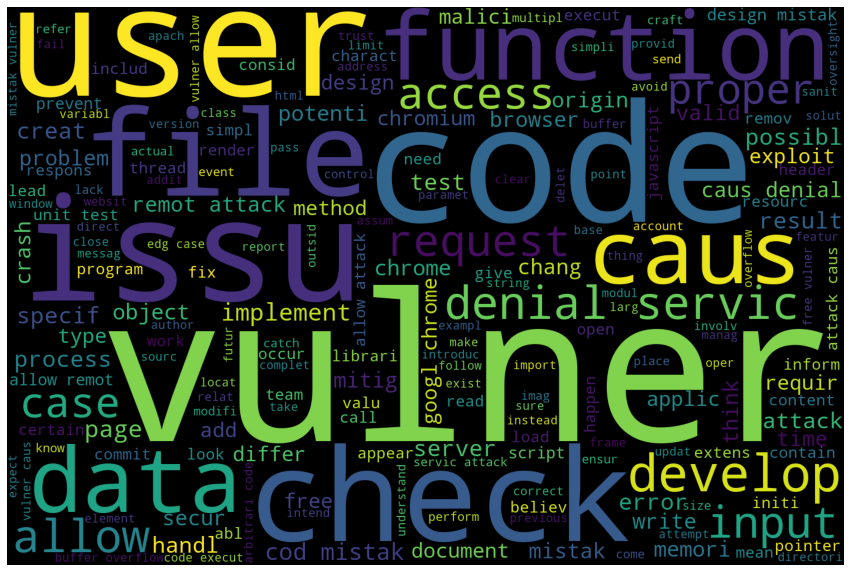

In [20]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
def plot_cloud(wordcloud):
    plt.figure(figsize=(15, 15))
    plt.imshow(wordcloud)
    plt.axis("off");
wordcloud = WordCloud(width = 1500, height = 1000, background_color='black',  random_state=10).generate( ''.join(map(str, processed_docs)).replace("'",'') )
plot_cloud(wordcloud)

In [21]:
def word2vec_model():
    w2v_model = Word2Vec(min_count=3,window=3,sample=1e-5, alpha=0.03,sg=1,min_alpha=0.0007,negative=20)
    
    w2v_model.build_vocab(processed_docs)
    w2v_model.train(processed_docs, total_examples=w2v_model.corpus_count, epochs=300, report_delay=1)
    
    return w2v_model

In [22]:
w2v_model = word2vec_model()
w2v_model.save('word2vec_model')

In [ ]:
import umap.umap_ as umap

In [ ]:
X = w2v_model.wv.vectors
cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,n_components=2, random_state=42).fit_transform(X)

#cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
 #                             n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(15,10))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

In [34]:
# Generate the average word2vec for the each title description

def vectors_test(): #test_df
    
    # Creating a list for storing the vectors (description into vectors)
    global word_embeddings_test
    word_embeddings_test = []
    test_processed_docs = data['description'].map(preprocess)
    
    # Reading the each book description 
    for line in test_processed_docs:
        avgword2vec = None
        count = 0
        for word in line:
            if word in w2v_model.wv:
                count += 1
                if avgword2vec is None:
                    avgword2vec = w2v_model.wv[word]
                else:
                    avgword2vec = avgword2vec + w2v_model.wv[word]
                
        if avgword2vec is not None:
            avgword2vec = avgword2vec / count
            word_embeddings_test.append(avgword2vec)
        else:
            word_embeddings_test.append(np.array([0]*50, dtype='float32'))

In [35]:
vectors_test()#train_df
# The Top 50 similar matches
def similarity(title):
    
    # finding cosine similarity for the vectors
    cosine_similarities = cosine_similarity(word_embeddings_test, word_embeddings_test)

    cntx = data[['description', 'id']]
    #Reverse mapping of the index
    indices = pd.Series(data.index, index = data['description']).drop_duplicates()
         
    idx = indices[title]
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    uplimit = len(data['description']) if len(data['description']) < 50 else 50
    sim_scores = sim_scores[0:uplimit]
    post_indices = [i[0] for i in sim_scores if i[1] > .9]
    recommend = cntx.iloc[post_indices]
    output=[]
    output.append(cntx.iloc[idx,1])
    for index, row in recommend.iterrows():
        output.append(row['id'])

    return ' '.join( np.unique(output))
    
    


In [53]:
CVE_description_mistake['matches'] = data['description'].apply(similarity)
    
CVE_description_mistake[['id', 'matches']].to_csv('submission.csv', index = False)

TypeError: sequence item 0: expected str instance, numpy.int64 found